## Why are we not using collate function?

Sparse embeddings typically operate on variable length data structures where it is not needed to be in the same shape where as dense embeddings require same shape tensors where input has a fixed shape, often we do some preprocessing on this such as offsets or padding so that embedding layer gets same shape input when batch processing. This makes it a requirement for collate function to be there in dense embeddings and it is not required in sparse embeddings.

In [34]:
!pip install torchinfo

In [35]:
!pip install torchmetrics

In [36]:
# Importing generic Libraries
import numpy as np
import pandas as pd
import sys

# Printing: Import the pprint function from the pprint module for formatted output of text
from pprint import pprint

In [37]:
# Import homework related libraries
## Dataload
from pathlib import Path
import joblib

## data processing libaries
from ast import literal_eval#to convert list elements to integer

## sklearn libraries
### preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
### split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import AdamW

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# to create vocab
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# for the random number fixing
import random

# Import HammingDistance from torchmetrics
# HammingDistance is useful for evaluating multi-label classification problems.
from torchmetrics import HammingDistance

#for clipping
from torch.nn.utils import clip_grad_value_

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import multilabel_confusion_matrix
from datetime import datetime


## Data Load

In [38]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive',force_remount=True)

  basepath = '/content/drive/MyDrive/NLP/Data_Folder'
  sys.path.append(basepath)
else:
  basepath = 'C:/Users/billa/Documents/UTD/Sem 5/NLP/Data_Folder'
  sys.path.append(basepath)

Mounted at /content/drive


In [39]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP/Data_Folder',
 '/content/drive/MyDrive/NLP/Data_Folder']

In [40]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Multilabel'
model_folder = base_folder /'Models/Multilabel'

In [41]:
multilabel_file = data_folder/ 'df_multilabel_hw_cleaned.joblib'
df = joblib.load(multilabel_file)

In [42]:
df.dropna(inplace=True)

### Y_var datatype

In [43]:
df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [44]:
X = df['cleaned_text']
y = df['Tag_Number'].apply(literal_eval)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

print(type(y) , y.shape, y[:6,:])
print(type(X) , X.shape, X.head(6))

<class 'numpy.ndarray'> (47427, 10) [[1 0 0 0 0 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]]
<class 'pandas.core.series.Series'> (47427,) 0    asp query stre dropdown webpage follow control...
1    run javascript code server java code want run ...
2    linq sql throw exception row find change hi li...
3    run python script php server run nginx web ser...
4    advice write function m try write function res...
5    jquery auto resize function cause jump browser...
Name: cleaned_text, dtype: object


In [45]:
# train_val_test split = 60%_20%_20%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle = True)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle = True)

# Print the shapes of the resulting sets
print("Training set shapes - X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("Validation set shapes - X_valid: {}, y_valid: {}".format(X_valid.shape, y_valid.shape))
print("Test set shapes - X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))

Training set shapes - X_train: (28456,), y_train: (28456, 10)
Validation set shapes - X_valid: (9485,), y_valid: (9485, 10)
Test set shapes - X_test: (9486,), y_test: (9486, 10)


In [46]:
type(X_train)

pandas.core.series.Series

## Part A (Neural Network in PyTorch Using Sparse Embeddings)

In [47]:
max_features = 5000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
X_train_fit = tfidf_vectorizer.fit_transform(X_train)
X_valid_fit = tfidf_vectorizer.transform(X_valid)
X_test_fit = tfidf_vectorizer.transform(X_test)

In [48]:
X_train_fit = torch.tensor(X_train_fit.toarray())
X_valid_fit = torch.tensor(X_valid_fit.toarray())
X_test_fit = torch.tensor(X_test_fit.toarray())

### create customdataset class

In [49]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y =y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        sample = (texts, labels)

        return sample

In [50]:
# Create an instance of the CustomDataset class for the training set
# This uses the cleaned training data and corresponding labels
trainset = CustomDataset(X_train_fit, y_train.astype(float))

# Create an instance of the CustomDataset class for the validation set
# This uses the cleaned validation data and corresponding labels
validset = CustomDataset(X_valid_fit, y_valid.astype(float))

# Create an instance of the CustomDataset class for the test set
# This uses the cleaned test data and corresponding labels
testset = CustomDataset(X_test_fit, y_test.astype(float))

In [51]:
# check the shape of the tensor
trainset

In [52]:
trainset[:][1]

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### check Data Loaders

In [53]:
batch_size = 2
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True)

### Tokenizer

In [54]:
# Creating a function that will be used to get the indices of words from vocab
# def tokenizer(x, vocab):
#     """Converts text to a list of indices using a vocabulary dictionary"""
#     return [vocab[token] for token in x.split()]

### Create simpleMLP model as defied in homework.

In [55]:
class SimpleMLP(nn.Module):
    def __init__(self, max_features, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        # Tf-IDF_layer->Linear <hidden_layer>->ReLU->Dropout->Batchnorm ->Linear<hidden_layer>->ReLU->Dropout->BatchNorm->Linear(output)

        # TF-idf layer
        # self.tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

        # First Linear layer
        self.linear1 = nn.Linear(max_features, hidden_dim1)
        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=drop_prob1)

        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)
        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=drop_prob2)

        # Final Linear layer
        self.linear3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, x):

        # First linear layer followed by ReLU,Dropout and BatchNorm
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        # Second linear layer followed by ReLU, Dropout and BatchNorm
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # Final linear layer
        x = self.linear3(x)

        return x

### Functions to train and evaluate Models

#### Step Function

In [56]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None, clip_value = None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """

    # Move the model and data to the device
    model = model.to(device)
    inputs = inputs.to(device).float()
    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets.float())

    # Step 2b: Calculate the Hamming distance


    # predicted = torch.argmax(outputs.data, 1)
    # correct = (predicted == targets).sum().item()
    predicted = (outputs > 0.5).float()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        clip_grad_value_(model.parameters(), clip_value=CLIP_VALUE)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, predicted
    else:
        return None, outputs, predicted

#### Train_Epoch()

In [57]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """

    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, predict = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        train_hamming_distance.update(predict, targets)


    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    hamming_dist = train_hamming_distance.compute()

    return train_loss, hamming_dist

#### val_epoch()

In [58]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss,_, predict = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            val_hamming_distance.update(predict, targets)

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    hamming_dist = val_hamming_distance.compute()

    return val_loss, hamming_dist

#### train() function

In [59]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamm_history = []
    valid_hamm_history = []

    # Initialize variables for early stopping
    best_valid_loss = float('inf')
    current_patience = 0

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hamm = train_epoch(train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamm = val_epoch(valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hamm_history.append(train_hamm)
        valid_loss_history.append(valid_loss)
        valid_hamm_history.append(valid_hamm)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train hamming distance: {train_hamm}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid hamming distance: {valid_hamm}")
        print()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            current_patience = 0  # Reset patience counter since validation loss improved
        else:
            current_patience += 1  # Increment patience counter

        # Check for early stopping
        if current_patience >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break

    return train_loss_history, train_hamm_history, valid_loss_history, valid_hamm_history

### Train

#### Hyperparameters

In [60]:
# model Parameters

MAX_FEATURES=5000
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.000
CLIP_TYPE = 'Value'
CLIP_VALUE = 10
PATIENCE = 5

#### Training Configuration

In [61]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
model_df = SimpleMLP(max_features = MAX_FEATURES ,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_df.parameters(), lr=LEARNING_RATE,  weight_decay = WEIGHT_DECAY)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Sanity Check

In [62]:
for inputs_, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs_ = inputs_.to(device).float()
    targets = targets.to(device)
    model_df = model_df.to(device)

    model_df.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_df(inputs_)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6772316132381093
Expected Theoretical loss: 0.6931471805599453


#### Training

In [63]:
# Call the train function to train the model
train_losses, train_hamm, valid_losses, valid_hamm = train(
    train_loader, valid_loader, model_df, optimizer, loss_function, EPOCHS, device, PATIENCE)



Epoch 1/5
Train Loss: 0.3455 | Train hamming distance: 0.08903217315673828
Valid Loss: 0.1431 | Valid hamming distance: 0.05051136016845703

Epoch 2/5
Train Loss: 0.1357 | Train hamming distance: 0.049560725688934326
Valid Loss: 0.1169 | Valid hamming distance: 0.043489694595336914

Epoch 3/5
Train Loss: 0.1081 | Train hamming distance: 0.04064518213272095
Valid Loss: 0.1104 | Valid hamming distance: 0.04094886779785156

Epoch 4/5
Train Loss: 0.0926 | Train hamming distance: 0.03512793779373169
Valid Loss: 0.1087 | Valid hamming distance: 0.04007381200790405

Epoch 5/5
Train Loss: 0.0829 | Train hamming distance: 0.03119903802871704
Valid Loss: 0.1069 | Valid hamming distance: 0.03840804100036621



In [64]:
# # Iterate over each tensor in the list and move them to CPU
# train_acc = [acc.cpu() for acc in train_acc]
# valid_acc = [acc.cpu() for acc in valid_acc]

### Plot losses and metrics

In [65]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

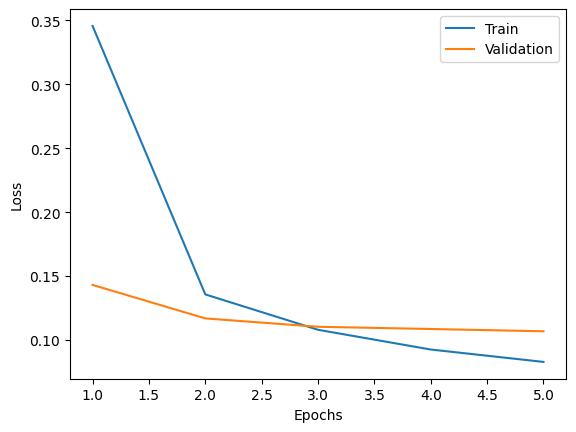

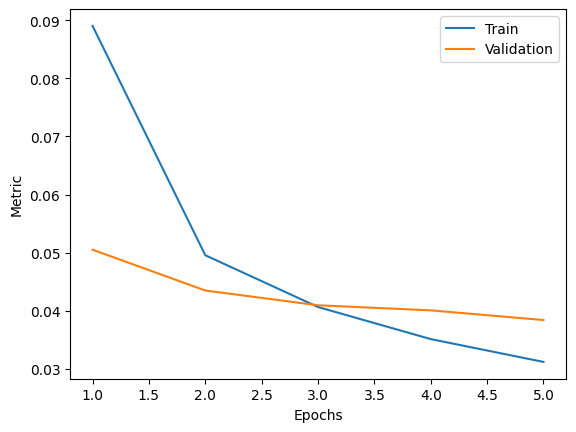

In [66]:
plot_history(train_losses, train_hamm, valid_losses, valid_hamm)

### Model checkpointing

In [67]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'hw4_b'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/NLP/Data_Folder/Models/Multilabel/2024-03-04_05-50-48_hw4_b.pt')

In [68]:
# Save the model's state dictionary to the specified file path
torch.save(model_df.state_dict(), path)


### Confusion Matrix

For detailed understanding of the performance of the model

In [73]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    train_hamming_distance = HammingDistance(task = "multilabel", num_labels = 10).to(device)
    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    model = model.to(device)

   # Set model to evaluation mode
    model.eval()


    running_correct = 0
    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            inputs = inputs.to(device)
            targets = targets.to(device)
            _, outputs,_ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            # Choose the label with maximum probability
            y_pred = (outputs > 0).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, y_pred))
            train_hamming_distance.update(y_pred, targets)
            y = torch.cat((y, targets.to(device)))

    # Calculate hamming distance by comparing the predicted and actual labels
    hamming_distance = train_hamming_distance.compute()

    # Return tuple containing predictions and accuracy
    return predictions, y, hamming_distance

In [74]:
# Get the prediction and accuracy
predictions_train, y_train, hamming_distance_train = get_acc_pred(train_loader, model_df,device)
predictions_valid, y_valid, hamming_distance_valid = get_acc_pred(valid_loader, model_df,device)
predictions_test, y_test, hamming_distance_test= get_acc_pred(test_loader, model_df, device)

In [75]:
# Print Hamming distance
print('train hamming distance', hamming_distance_train)
print('Valid hamming distance', hamming_distance_valid)
print('test hamming distance', hamming_distance_test)

train hamming distance tensor(0.0159)
Valid hamming distance tensor(0.0374)
test hamming distance tensor(0.0396)


In [76]:
multilabel_confusion_matrix(y_true=y_train.cpu(), y_pred=predictions_train.cpu())

array([[[21916,   326],
        [  614,  5600]],

       [[23344,   110],
        [  226,  4776]],

       [[24954,    85],
        [  395,  3022]],

       [[11359,   617],
        [  377, 16103]],

       [[23818,    41],
        [  125,  4472]],

       [[13178,   202],
        [  213, 14863]],

       [[28008,    23],
        [  379,    46]],

       [[28124,     0],
        [  174,   158]],

       [[28273,     1],
        [  135,    47]],

       [[20733,   230],
        [  257,  7236]]])

In [77]:
multilabel_confusion_matrix(y_true=y_valid.cpu(), y_pred=predictions_valid.cpu())

array([[[7121,  250],
        [ 380, 1734]],

       [[7789,   77],
        [ 151, 1468]],

       [[8250,   72],
        [ 337,  826]],

       [[3517,  508],
        [ 281, 5179]],

       [[7960,   43],
        [ 137, 1345]],

       [[4155,  302],
        [ 209, 4819]],

       [[9312,    8],
        [ 148,   17]],

       [[9358,    2],
        [  81,   44]],

       [[9423,    1],
        [  56,    5]],

       [[6791,  223],
        [ 281, 2190]]])

In [78]:
multilabel_confusion_matrix(y_true=y_test.cpu(), y_pred=predictions_test.cpu())

array([[[7085,  278],
        [ 418, 1705]],

       [[7726,   74],
        [ 186, 1500]],

       [[8237,   97],
        [ 344,  808]],

       [[3548,  521],
        [ 259, 5158]],

       [[7909,   49],
        [ 153, 1375]],

       [[4227,  325],
        [ 238, 4696]],

       [[9309,    8],
        [ 159,   10]],

       [[9354,    2],
        [  82,   48]],

       [[9414,    0],
        [  60,   12]],

       [[6774,  210],
        [ 298, 2204]]])

### Hamming distance of Test Data

In [80]:
trained_model_df = SimpleMLP(max_features = MAX_FEATURES ,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

checkpoint = torch.load(path)
trained_model_df.load_state_dict(checkpoint)

<All keys matched successfully>

In [81]:
# Get the prediction and accuracy
predictions_test, labels_test, hamming_distance_test = get_acc_pred(test_loader, trained_model_df, device)

In [82]:
# Print Test Accuracy
print('Test Hamming distance', hamming_distance_test)

Test Hamming distance tensor(0.0396)


In [83]:
test_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
test_hamming_distance.update(labels_test, predictions_test)

In [84]:
test_hamming_distance.compute()

tensor(0.0396)

In [85]:
sample_X = X_test[0:5]
sample_X

6082     open fancybox pageload situation open fancy bo...
18123    create work array image android struggle work ...
16377    hide image filter table work web page large ta...
27029    javascript namespace issue value function m su...
6433     unescape javascript escape c function c handle...
Name: cleaned_text, dtype: object

In [88]:
X_sample = tfidf_vectorizer.transform(sample_X)
X_sample = torch.Tensor(X_sample.toarray())
X_sample =X_sample.to(device)

In [89]:
model_df.to(device)
model_df.eval()
# get outputs (logits) from model
outputs = model_df(X_sample)

In [90]:
# get predicted labels
predictions = outputs > 0.5

# mapping for class labels
mapping = {0: 'c#', 1: 'java', 2: 'php', 3: 'javascript', 4: 'android', 5: 'jquery', 6: 'c++', 7: 'python', 8: 'iphone', 9: 'asp.net'}

predicted_label_names = []
for sample_pred in predictions:
    labels = [mapping[i] for i, val in enumerate(sample_pred) if val == 1]
    predicted_label_names.append(labels)

print(predicted_label_names)

[['asp.net'], ['java', 'android'], ['javascript', 'jquery'], ['javascript', 'jquery'], ['javascript']]
